In [1]:
# Import libraries
from prophet import Prophet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


C:\Users\2003l\AppData\Local\Temp\ipykernel_15396\1560831322.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("dataset.csv", parse_dates=['timestamp'])


<Axes: xlabel='ds'>

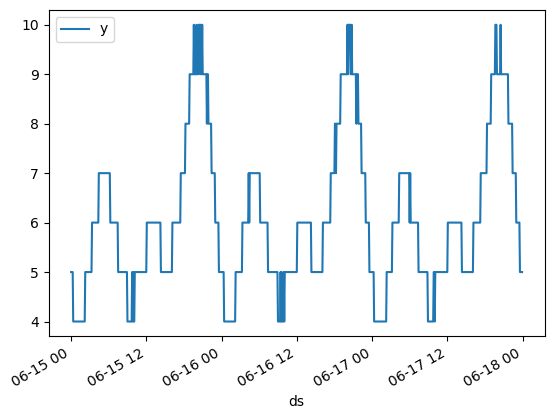

In [2]:
# read the data of csv file
df = pd.read_csv("dataset.csv", parse_dates=['timestamp'])

# Rename columns to match Prophet requirements
df = df.rename(columns={"value": "y", "timestamp": "ds"})

# needed parameters
resolution = 5 #in minutes
no_of_days  = 10
no_of_samples_per_day = int(24*60/resolution)
no_of_samples = no_of_samples_per_day * no_of_days

# Amplitute parameters
throughput_per_replica = 50

# Scale the value to get replicas
df["y"] = (df["y"] / throughput_per_replica).apply(np.round)

df.head(no_of_samples_per_day*3).plot(kind='line', x='ds', y='y')


In [3]:
# Split data into training & testing data
df_train = df.head(no_of_samples_per_day*6)
df_test = df.tail(no_of_samples_per_day*4)


In [4]:
# Create and fit a prophet model
model = Prophet()
model.fit(df_train)


10:09:09 - cmdstanpy - INFO - Chain [1] start processing
10:09:09 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\2003l\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\2003l\anaconda3\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\2003l\anaconda3\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, ca

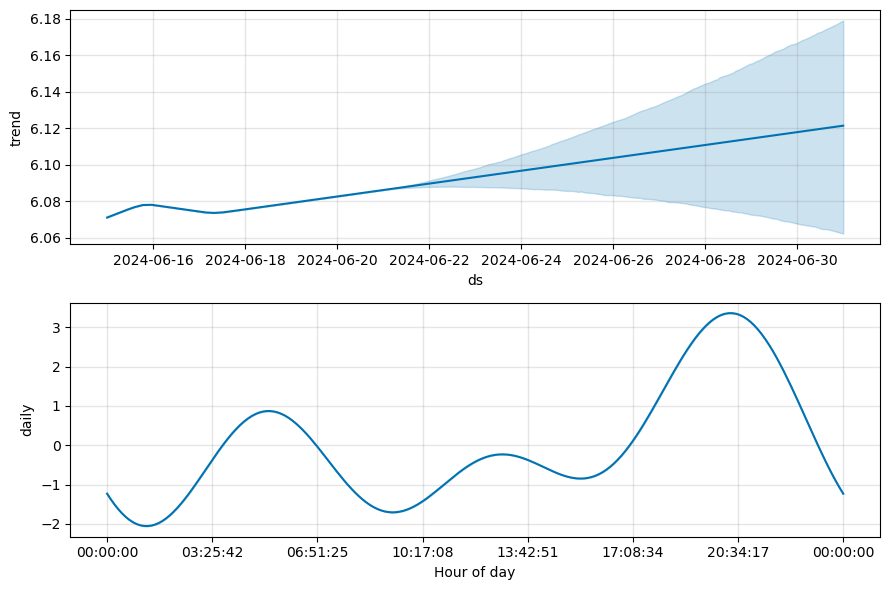

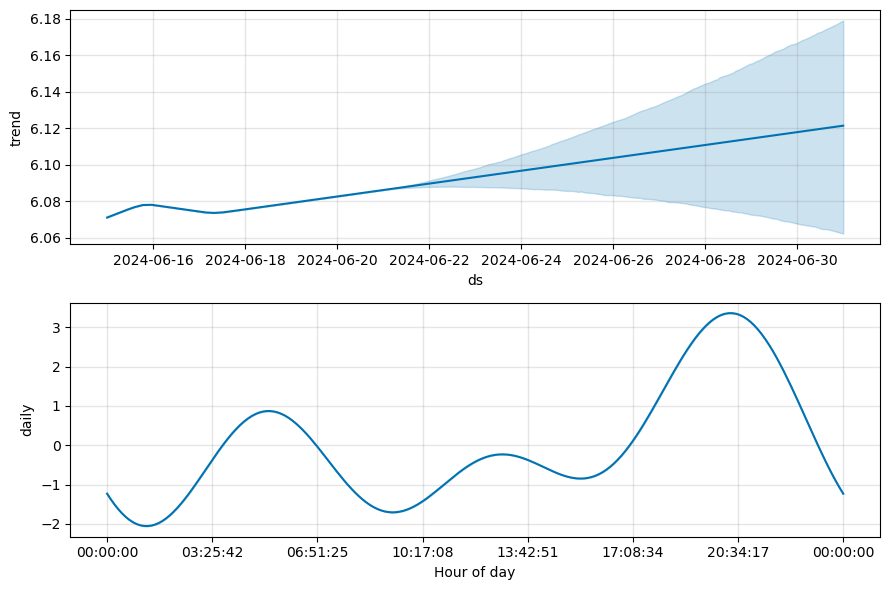

In [5]:
# Predict future values for 10 days
future = model.make_future_dataframe(periods=no_of_samples_per_day*10, freq='{}min'.format(resolution))

forecast = model.predict(future)
forecast['forecasted_y'] = forecast['yhat'].apply(np.ceil)

# Plot the components of the forecast
model.plot_components(forecast)


<Axes: xlabel='ds'>

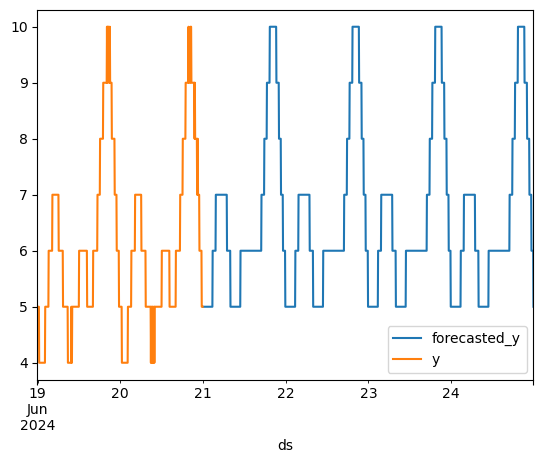

In [6]:
# Plot the actual and forecasted data
ax = forecast.tail(no_of_samples_per_day*10).head(no_of_samples_per_day*4).plot(kind='line', x='ds', y='forecasted_y')
df_train.tail(no_of_samples_per_day*2).plot(x='ds', y='y', ax=ax)


In [7]:
#root mean squared error
from sklearn.metrics import mean_squared_error

# Get the actual values from the original dataframe
actual = df_test['y']

# Get the predicted values from the forecasted dataframe
predicted = forecast['forecasted_y'].tail(no_of_samples_per_day*4)

# Calculate the rmse
rmse = np.sqrt(mean_squared_error(actual, predicted))

# Print the rmse
print(f"RMSE: {rmse:.2f}; {rmse * 100 / df_test['y'].max():.2f}%")


RMSE: 0.72; 7.18%


In [8]:
# Save the prediction in a csv file
forecast = forecast.rename(columns={"forecasted_y": "value", "ds": "timestamp"})
forecast.tail(no_of_samples_per_day*6).to_csv('prediction.csv', columns=['timestamp','value'], index=False)